# Base Sequence Quality

#### Import Dependencies

In [1]:
from pathlib import Path
import subprocess

import pandas as pd
import polars as pl
import polars_bio as pb

INFO:polars_bio:Creating BioSessionContext


#### Common

Load data

In [2]:
root_path = Path("./../../")
example_path = root_path / "tests/data/base_quality/example.fastq"
bench_path = root_path / "tests/data/base_quality/bench.fastq"

example_data = pb.read_fastq(str(example_path))
bench_data = pb.read_fastq(str(bench_path))

INFO:polars_bio:Table: example registered for path: ../../tests/data/base_quality/example.fastq
INFO:polars_bio:Table: bench registered for path: ../../tests/data/base_quality/bench.fastq


Set target partitions

In [3]:
pb.set_option("datafusion.execution.target_partitions", "1")

## Implementation

### UDTF for Quality Histogram

The exposed UDTF `quality_histogram` takes the name of a table containing sequencing data and the name of the column with quality score strings. It returns a partial histogram of quality scores in the form of rows:

```
position | score | count
```

Each row represents how many times a specific quality `score` occurred at a given `position` within the quality strings.


In [4]:
quality_histogram = pb.sql(
"""
SELECT 
    pos, 
    score, 
    count 
FROM 
    quality_histogram('example', 'quality_scores')
""").collect()

quality_histogram.filter(pl.col("pos") == 0).sort("score")

0rows [00:00, ?rows/s]

pos,score,count
u64,u8,u64
0,2,13
0,10,2
0,16,1
0,26,4
0,27,3
0,28,2
0,30,13
0,31,55
0,33,9


To get the full histogram, the output should be **grouped by `position` and `score`** and the `count` values should be **aggregated using `SUM(count)`**.

In [5]:
quality_histogram_grouped = pb.sql(
"""
SELECT 
    pos, 
    score, 
    SUM(count) AS count 
FROM 
    quality_histogram('example', 'quality_scores') 
GROUP BY 
    pos, score
""").collect()

quality_histogram_grouped.filter(pl.col("pos") == 0).sort("score")

0rows [00:00, ?rows/s]

pos,score,count
u64,u8,u64
0,2,13
0,10,2
0,16,1
0,26,4
0,27,3
0,28,2
0,30,13
0,31,55
0,33,9


### UDAF for Quality Stats from Quality Histograms

The exposed UDAF `quality_quartiles` takes two input columns: `score` (UInt8) and `count` (UInt64), which represent a quality score histogram. It aggregates these values to compute statistical summaries for a given group (e.g., per base position), returning:

```
avg | lower | q1 | median | q3 | upper
```

This function is designed to be used after grouping the histogram by `position`.

In [6]:
quality_stats = pb.sql(
"""
SELECT 
    pos, 
    stats.avg AS avg, 
    stats.lower AS lower, 
    stats.q1 AS q1,
    stats.median AS median,
    stats.q3 AS q3,
    stats.upper AS upper
FROM (
    SELECT 
        pos, 
        quality_quartiles(score, count) AS stats 
    FROM (
        SELECT 
            * 
        FROM 
            quality_histogram('example', 'quality_scores')
    ) 
    GROUP BY 
        pos
    )
""").collect()

quality_stats.sort("pos")

0rows [00:00, ?rows/s]

pos,avg,lower,q1,median,q3,upper
u64,f64,f64,f64,f64,f64,f64
0,30.135,26.5,31.0,33.0,34.0,38.5
1,31.21,26.5,31.0,34.0,34.0,38.5
2,32.015,26.5,31.0,34.0,34.0,38.5
3,35.69,32.0,35.0,37.0,37.0,40.0
4,35.68,32.0,35.0,37.0,37.0,40.0
…,…,…,…,…,…,…
96,31.315,27.5,32.0,34.0,35.0,39.5
97,30.67,25.0,31.0,34.0,35.0,41.0
98,31.55,27.5,32.0,34.0,35.0,39.5


For example the `quality_quartiles` UDAF can be used to filter positions with the lowest average read quality.

In [7]:
quality_stats_where_low_avg = pb.sql(
"""
SELECT 
    pos, 
    stats.avg AS avg
FROM (
    SELECT 
        pos, 
        quality_quartiles(score, count) AS stats 
    FROM (
        SELECT 
            * 
        FROM 
            quality_histogram('example', 'quality_scores')
    ) 
    GROUP BY 
        pos
    )
WHERE
    stats.avg < 35
""").collect()

quality_stats_where_low_avg.sort("pos")

0rows [00:00, ?rows/s]

pos,avg
u64,f64
0,30.135
1,31.21
2,32.015
69,33.7
70,33.565
…,…
96,31.315
97,30.67
98,31.55


### Base Sequence Quality Function

We expose the `polars-bio` function `base_sequence_quality`, which takes a DataFrame and the name of the column containing quality scores, and returns a DataFrame with computed quality statistics for each base position.

#### Supports different inputs

* Supports polars.LazyFrame as input

In [8]:
x = pb.base_sequence_quality(example_data, "quality_scores")
x.sort("pos").limit(10), type(x), type(example_data)

0rows [00:00, ?rows/s]

(shape: (10, 7)
 ┌─────┬────────┬───────┬──────┬────────┬──────┬───────┐
 │ pos ┆ avg    ┆ lower ┆ q1   ┆ median ┆ q3   ┆ upper │
 │ --- ┆ ---    ┆ ---   ┆ ---  ┆ ---    ┆ ---  ┆ ---   │
 │ u64 ┆ f64    ┆ f64   ┆ f64  ┆ f64    ┆ f64  ┆ f64   │
 ╞═════╪════════╪═══════╪══════╪════════╪══════╪═══════╡
 │ 0   ┆ 30.135 ┆ 26.5  ┆ 31.0 ┆ 33.0   ┆ 34.0 ┆ 38.5  │
 │ 1   ┆ 31.21  ┆ 26.5  ┆ 31.0 ┆ 34.0   ┆ 34.0 ┆ 38.5  │
 │ 2   ┆ 32.015 ┆ 26.5  ┆ 31.0 ┆ 34.0   ┆ 34.0 ┆ 38.5  │
 │ 3   ┆ 35.69  ┆ 32.0  ┆ 35.0 ┆ 37.0   ┆ 37.0 ┆ 40.0  │
 │ 4   ┆ 35.68  ┆ 32.0  ┆ 35.0 ┆ 37.0   ┆ 37.0 ┆ 40.0  │
 │ 5   ┆ 35.095 ┆ 32.0  ┆ 35.0 ┆ 35.0   ┆ 37.0 ┆ 40.0  │
 │ 6   ┆ 35.145 ┆ 32.0  ┆ 35.0 ┆ 35.0   ┆ 37.0 ┆ 40.0  │
 │ 7   ┆ 35.4   ┆ 32.0  ┆ 35.0 ┆ 36.0   ┆ 37.0 ┆ 40.0  │
 │ 8   ┆ 37.625 ┆ 34.0  ┆ 37.0 ┆ 39.0   ┆ 39.0 ┆ 42.0  │
 │ 9   ┆ 37.36  ┆ 34.0  ┆ 37.0 ┆ 39.0   ┆ 39.0 ┆ 42.0  │
 └─────┴────────┴───────┴──────┴────────┴──────┴───────┘,
 polars.dataframe.frame.DataFrame,
 polars.lazyframe.frame.LazyFrame)

* Supports polars.DataFrames as input

In [9]:
example_polars_df = example_data.collect()
x = pb.base_sequence_quality(example_polars_df, "quality_scores")
x.sort("pos").limit(10), type(x), type(example_polars_df)

0rows [00:00, ?rows/s]

(shape: (10, 7)
 ┌─────┬────────┬───────┬──────┬────────┬──────┬───────┐
 │ pos ┆ avg    ┆ lower ┆ q1   ┆ median ┆ q3   ┆ upper │
 │ --- ┆ ---    ┆ ---   ┆ ---  ┆ ---    ┆ ---  ┆ ---   │
 │ u64 ┆ f64    ┆ f64   ┆ f64  ┆ f64    ┆ f64  ┆ f64   │
 ╞═════╪════════╪═══════╪══════╪════════╪══════╪═══════╡
 │ 0   ┆ 30.135 ┆ 26.5  ┆ 31.0 ┆ 33.0   ┆ 34.0 ┆ 38.5  │
 │ 1   ┆ 31.21  ┆ 26.5  ┆ 31.0 ┆ 34.0   ┆ 34.0 ┆ 38.5  │
 │ 2   ┆ 32.015 ┆ 26.5  ┆ 31.0 ┆ 34.0   ┆ 34.0 ┆ 38.5  │
 │ 3   ┆ 35.69  ┆ 32.0  ┆ 35.0 ┆ 37.0   ┆ 37.0 ┆ 40.0  │
 │ 4   ┆ 35.68  ┆ 32.0  ┆ 35.0 ┆ 37.0   ┆ 37.0 ┆ 40.0  │
 │ 5   ┆ 35.095 ┆ 32.0  ┆ 35.0 ┆ 35.0   ┆ 37.0 ┆ 40.0  │
 │ 6   ┆ 35.145 ┆ 32.0  ┆ 35.0 ┆ 35.0   ┆ 37.0 ┆ 40.0  │
 │ 7   ┆ 35.4   ┆ 32.0  ┆ 35.0 ┆ 36.0   ┆ 37.0 ┆ 40.0  │
 │ 8   ┆ 37.625 ┆ 34.0  ┆ 37.0 ┆ 39.0   ┆ 39.0 ┆ 42.0  │
 │ 9   ┆ 37.36  ┆ 34.0  ┆ 37.0 ┆ 39.0   ┆ 39.0 ┆ 42.0  │
 └─────┴────────┴───────┴──────┴────────┴──────┴───────┘,
 polars.dataframe.frame.DataFrame,
 polars.dataframe.frame.DataFrame)

* Supports pandas.DataFrame as input

In [10]:
example_pandas = example_data.collect().to_pandas()
x = pb.base_sequence_quality(example_pandas, "quality_scores")
x.sort("pos").limit(10), type(x), type(example_pandas)

0rows [00:00, ?rows/s]

(shape: (10, 7)
 ┌─────┬────────┬───────┬──────┬────────┬──────┬───────┐
 │ pos ┆ avg    ┆ lower ┆ q1   ┆ median ┆ q3   ┆ upper │
 │ --- ┆ ---    ┆ ---   ┆ ---  ┆ ---    ┆ ---  ┆ ---   │
 │ u64 ┆ f64    ┆ f64   ┆ f64  ┆ f64    ┆ f64  ┆ f64   │
 ╞═════╪════════╪═══════╪══════╪════════╪══════╪═══════╡
 │ 0   ┆ 30.135 ┆ 26.5  ┆ 31.0 ┆ 33.0   ┆ 34.0 ┆ 38.5  │
 │ 1   ┆ 31.21  ┆ 26.5  ┆ 31.0 ┆ 34.0   ┆ 34.0 ┆ 38.5  │
 │ 2   ┆ 32.015 ┆ 26.5  ┆ 31.0 ┆ 34.0   ┆ 34.0 ┆ 38.5  │
 │ 3   ┆ 35.69  ┆ 32.0  ┆ 35.0 ┆ 37.0   ┆ 37.0 ┆ 40.0  │
 │ 4   ┆ 35.68  ┆ 32.0  ┆ 35.0 ┆ 37.0   ┆ 37.0 ┆ 40.0  │
 │ 5   ┆ 35.095 ┆ 32.0  ┆ 35.0 ┆ 35.0   ┆ 37.0 ┆ 40.0  │
 │ 6   ┆ 35.145 ┆ 32.0  ┆ 35.0 ┆ 35.0   ┆ 37.0 ┆ 40.0  │
 │ 7   ┆ 35.4   ┆ 32.0  ┆ 35.0 ┆ 36.0   ┆ 37.0 ┆ 40.0  │
 │ 8   ┆ 37.625 ┆ 34.0  ┆ 37.0 ┆ 39.0   ┆ 39.0 ┆ 42.0  │
 │ 9   ┆ 37.36  ┆ 34.0  ┆ 37.0 ┆ 39.0   ┆ 39.0 ┆ 42.0  │
 └─────┴────────┴───────┴──────┴────────┴──────┴───────┘,
 polars.dataframe.frame.DataFrame,
 pandas.core.frame.DataFrame)

* Supports dataframe path or table name as input

In [11]:
x = pb.base_sequence_quality("example", "quality_scores")
x.sort("pos").limit(10), type(x)

(shape: (10, 7)
 ┌─────┬────────┬───────┬──────┬────────┬──────┬───────┐
 │ pos ┆ avg    ┆ lower ┆ q1   ┆ median ┆ q3   ┆ upper │
 │ --- ┆ ---    ┆ ---   ┆ ---  ┆ ---    ┆ ---  ┆ ---   │
 │ u64 ┆ f64    ┆ f64   ┆ f64  ┆ f64    ┆ f64  ┆ f64   │
 ╞═════╪════════╪═══════╪══════╪════════╪══════╪═══════╡
 │ 0   ┆ 30.135 ┆ 26.5  ┆ 31.0 ┆ 33.0   ┆ 34.0 ┆ 38.5  │
 │ 1   ┆ 31.21  ┆ 26.5  ┆ 31.0 ┆ 34.0   ┆ 34.0 ┆ 38.5  │
 │ 2   ┆ 32.015 ┆ 26.5  ┆ 31.0 ┆ 34.0   ┆ 34.0 ┆ 38.5  │
 │ 3   ┆ 35.69  ┆ 32.0  ┆ 35.0 ┆ 37.0   ┆ 37.0 ┆ 40.0  │
 │ 4   ┆ 35.68  ┆ 32.0  ┆ 35.0 ┆ 37.0   ┆ 37.0 ┆ 40.0  │
 │ 5   ┆ 35.095 ┆ 32.0  ┆ 35.0 ┆ 35.0   ┆ 37.0 ┆ 40.0  │
 │ 6   ┆ 35.145 ┆ 32.0  ┆ 35.0 ┆ 35.0   ┆ 37.0 ┆ 40.0  │
 │ 7   ┆ 35.4   ┆ 32.0  ┆ 35.0 ┆ 36.0   ┆ 37.0 ┆ 40.0  │
 │ 8   ┆ 37.625 ┆ 34.0  ┆ 37.0 ┆ 39.0   ┆ 39.0 ┆ 42.0  │
 │ 9   ┆ 37.36  ┆ 34.0  ┆ 37.0 ┆ 39.0   ┆ 39.0 ┆ 42.0  │
 └─────┴────────┴───────┴──────┴────────┴──────┴───────┘,
 polars.dataframe.frame.DataFrame)

#### And outputs

* Supports polars.DataFrame as output

In [12]:
x = pb.base_sequence_quality("example", "quality_scores", output_type="polars.DataFrame")
x.sort("pos").limit(10), type(x)

(shape: (10, 7)
 ┌─────┬────────┬───────┬──────┬────────┬──────┬───────┐
 │ pos ┆ avg    ┆ lower ┆ q1   ┆ median ┆ q3   ┆ upper │
 │ --- ┆ ---    ┆ ---   ┆ ---  ┆ ---    ┆ ---  ┆ ---   │
 │ u64 ┆ f64    ┆ f64   ┆ f64  ┆ f64    ┆ f64  ┆ f64   │
 ╞═════╪════════╪═══════╪══════╪════════╪══════╪═══════╡
 │ 0   ┆ 30.135 ┆ 26.5  ┆ 31.0 ┆ 33.0   ┆ 34.0 ┆ 38.5  │
 │ 1   ┆ 31.21  ┆ 26.5  ┆ 31.0 ┆ 34.0   ┆ 34.0 ┆ 38.5  │
 │ 2   ┆ 32.015 ┆ 26.5  ┆ 31.0 ┆ 34.0   ┆ 34.0 ┆ 38.5  │
 │ 3   ┆ 35.69  ┆ 32.0  ┆ 35.0 ┆ 37.0   ┆ 37.0 ┆ 40.0  │
 │ 4   ┆ 35.68  ┆ 32.0  ┆ 35.0 ┆ 37.0   ┆ 37.0 ┆ 40.0  │
 │ 5   ┆ 35.095 ┆ 32.0  ┆ 35.0 ┆ 35.0   ┆ 37.0 ┆ 40.0  │
 │ 6   ┆ 35.145 ┆ 32.0  ┆ 35.0 ┆ 35.0   ┆ 37.0 ┆ 40.0  │
 │ 7   ┆ 35.4   ┆ 32.0  ┆ 35.0 ┆ 36.0   ┆ 37.0 ┆ 40.0  │
 │ 8   ┆ 37.625 ┆ 34.0  ┆ 37.0 ┆ 39.0   ┆ 39.0 ┆ 42.0  │
 │ 9   ┆ 37.36  ┆ 34.0  ┆ 37.0 ┆ 39.0   ┆ 39.0 ┆ 42.0  │
 └─────┴────────┴───────┴──────┴────────┴──────┴───────┘,
 polars.dataframe.frame.DataFrame)

* Supports pandas.DataFrame as output

In [13]:
x = pb.base_sequence_quality("example", "quality_scores", output_type="pandas.DataFrame")
x, type(x)

(     pos     avg  lower    q1  median    q3  upper
 0      0  30.135   26.5  31.0    33.0  34.0   38.5
 1      1  31.210   26.5  31.0    34.0  34.0   38.5
 2      2  32.015   26.5  31.0    34.0  34.0   38.5
 3      3  35.690   32.0  35.0    37.0  37.0   40.0
 4      4  35.680   32.0  35.0    37.0  37.0   40.0
 ..   ...     ...    ...   ...     ...   ...    ...
 96    96  31.315   27.5  32.0    34.0  35.0   39.5
 97    97  30.670   25.0  31.0    34.0  35.0   41.0
 98    98  31.550   27.5  32.0    34.0  35.0   39.5
 99    99  31.250   27.5  32.0    34.0  35.0   39.5
 100  100  31.105   25.0  31.0    34.0  35.0   41.0
 
 [101 rows x 7 columns],
 pandas.core.frame.DataFrame)

### Visualization

0rows [00:00, ?rows/s]

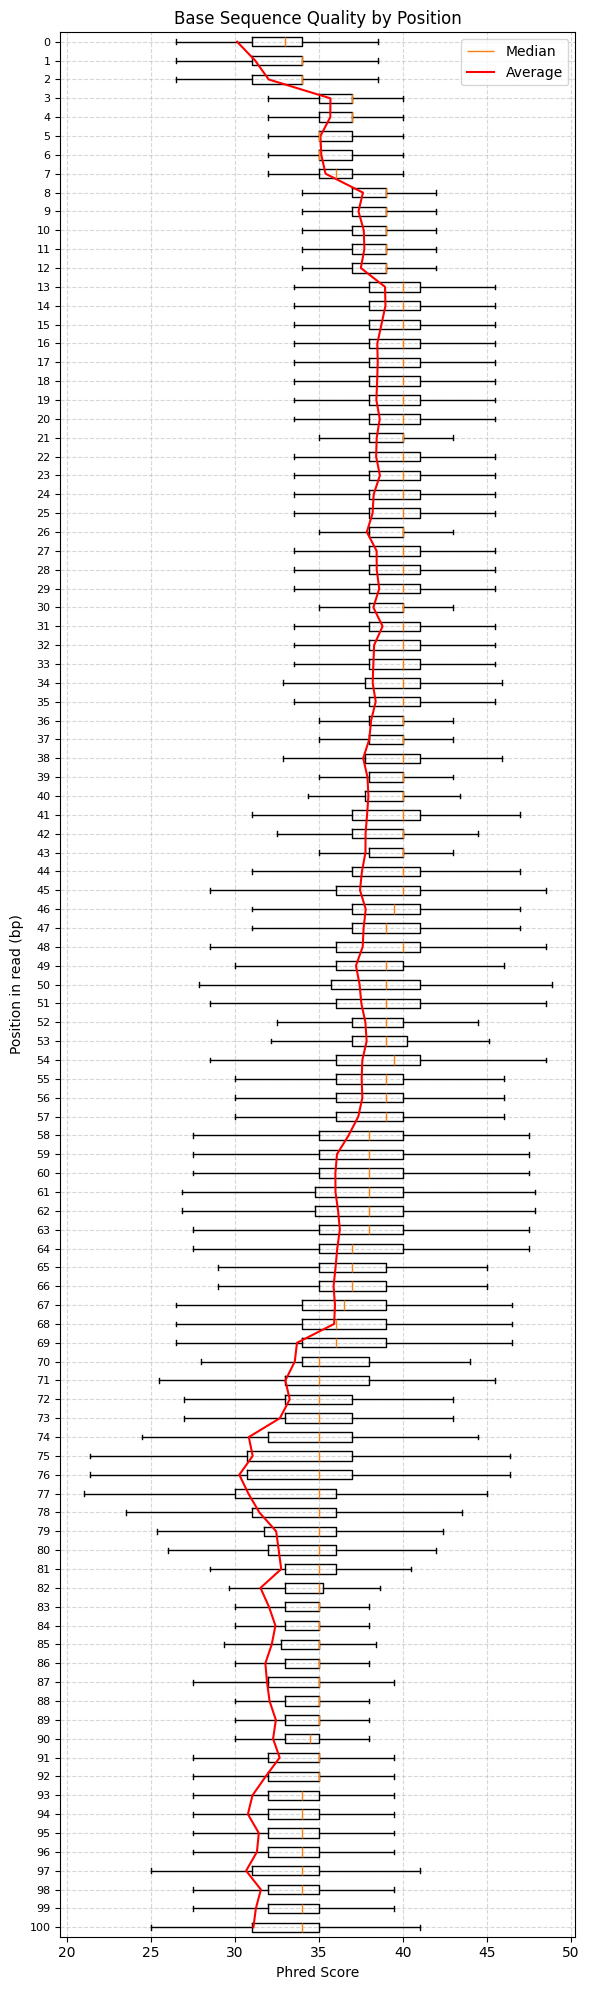

In [14]:
df = pb.base_sequence_quality(example_data, "quality_scores")
pb.visualize_base_sequence_quality(df)

#### Reference

![Base Sequence Quality](./../assets/base_sequence_quality.png)

## Benchmarks

### Reference

The implementation is validated against `fastqc-rs` [fastqc-rs](https://github.com/fastqc-rs/fastqc-rs), which computes the same quality metrics and presents them in an HTML report.

In [15]:
%%timeit -n 1 -r 7
subprocess.run(["fqc", "-q", str(bench_path)], stdout=subprocess.DEVNULL)

40.5 s ± 1.13 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Implemented Method

- Single partition

In [16]:
pb.set_option("datafusion.execution.target_partitions", "1")

In [17]:
%%timeit -n 1 -r 7
x = pb.base_sequence_quality("bench", "quality_scores")

26.2 s ± 1.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


- 2x partitions

In [18]:
pb.set_option("datafusion.execution.target_partitions", "2")

In [19]:
%%timeit -n 1 -r 7
x = pb.base_sequence_quality("bench", "quality_scores")

16.1 s ± 421 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
